In [1]:
## file twi_neo_repeat3_iz_np1_v2.2_10yrs.db available at: https://s3df.slac.stanford.edu/groups/rubin/static/sim-data/defunct_sims_featureScheduler_runs2.2/twilight_neo/
##  DO NOT ADD TO THE REPO!!!!


In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import sqlite3
from scipy.stats import binned_statistic
import rubin_sim.maf as maf

In [3]:
# Let's make a plot looking at how the twilight NEO observations are distributed

bundleList = []

nside=64
metric = maf.CountMetric(col='night')
sql = 'night < 366 and visitExposureTime < 20'

slicer = maf.HealpixSlicer(
        nside=nside,
        latCol='altitude',
        lonCol='azimuth',
        useCache=False)
plotFuncs = [maf.LambertSkyMap()]
plotDict = {"norm": "log", 'title': 'Twilight NEO Observations',
           'xlabel': 'N Observations'}

bundle = maf.MetricBundle(
            metric,
            slicer,
            sql,
            plotFuncs=plotFuncs,
            plotDict=plotDict,
        )
bundleList.append(bundle)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


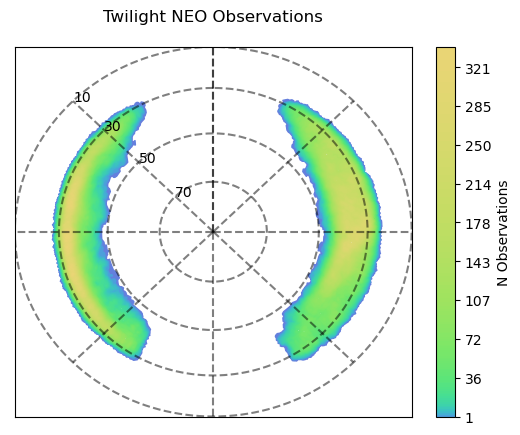

In [4]:
bg = maf.MetricBundleGroup([bundle], 'twi_neo_repeat3_iz_np1_v2.2_10yrs.db', 'temp', None)
bg.runAll()
bg.plotAll(closefigs=False)

oneweb 0.01373660824602918
slv1 0.005185290160562576
slv2 0.039243625446929165


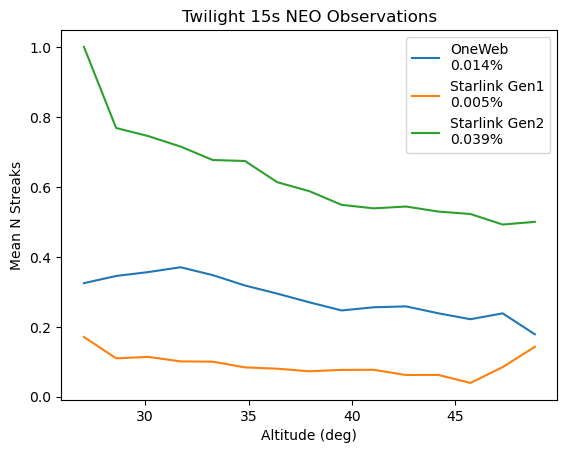

In [5]:
tags = ['oneweb', 'slv1', 'slv2']
pix_width = 50
pixscale = 0.2
n_pix = 2.9e9

labels = {'slv1': 'Starlink Gen1',
          'slv2': 'Starlink Gen2',
          'oneweb': 'OneWeb'}

con = sqlite3.connect('twi_neo_repeat3_iz_np1_v2.2_10yrs.db')

for tag in tags:
    orig = pd.read_sql('select * from observations where night < 366', con)
    data = np.load('twi_neo_repeat3_iz_np1_v2.2_10yrs%s.npz' % tag)['obs_array'].copy()
    indx = np.in1d(orig['observationId'].values, data['observationId'])
    
    orig = orig.iloc[np.where(indx == True)[0]]
    
    twi_indx = np.where(orig['visitExposureTime'] < 20)[0]
    reg_indx = np.where(orig['visitExposureTime'] >= 20)[0]

    
    pix_lost = data['streak_len_deg'][twi_indx].mean() * 3600/pixscale * pix_width  # pix per image
    pix_lost_percent = pix_lost/n_pix*100
    
    print(tag, pix_lost_percent)
    
    mean_n_s, alts, bd = binned_statistic(orig['altitude'].values[twi_indx], data['n_streaks'][twi_indx], bins=15)
    plt.plot(alts[1:], mean_n_s, label=labels[tag]+'\n%.3f%%' % pix_lost_percent)

plt.legend()
plt.xlabel('Altitude (deg)')
plt.ylabel('Mean N Streaks')
plt.title('Twilight 15s NEO Observations')
plt.savefig('twilight_curves.pdf')
con.close()

In [6]:
# sanity check, one 3.5 degree streak wipes out what % of pixels?
3.5*3600/.2*50/2.9e9*100

0.10862068965517241